https://github.com/dpmlab/Anticipation-of-temporally-structured-events/blob/8fbd488c04d47148f9a53048de5d05a90e1c1663/s_light.py#L311

# Import Libraries

In [3]:
import os
import math
import time
import pickle
import numpy as np
import deepdish as dd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr
from brainiak.eventseg.event import EventSegment
from sklearn.model_selection import train_test_split
import nibabel as nib

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, ttest_1samp
from statsmodels.stats.multitest import multipletests

from nilearn import plotting, image
from nibabel.viewers import OrthoSlicer3D

from scipy.stats import norm

# Helper Functions

## 2D Maps (repeat, vox)

In [4]:
def create_2d_vox_map(sl_timescales, filtered_SLs=None): 

    # Number of valid voxels
    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    coords = np.transpose(np.where(non_nan_mask))
    nVox = coords.shape[0]

    # check if nan:
    if not np.all(np.isfinite(non_nan_mask)):
        print("Non-finite values detected in NIfTI data.")

    # Indices of voxels belonging to each searchlight
    SL_voxels = pickle.load(open('../data/SL/SL_allvox.p', 'rb'))

    # number of movie repeats
    nMaps = len(sl_timescales[list(sl_timescales.keys())[0]])

    # Arrays for voxel maps and voxel searchlight count
    vox_map_2d = np.zeros((nMaps, nVox))
    voxel_SLcount = np.zeros(nVox)
    
    if not filtered_SLs:
        SLs = sl_timescales
    else:
        SLs = filtered_SLs
    
    # Iterate over searchlights and voxels
    for sl_idx in SLs:
        for m in range(nMaps):
            voxels_per_sl = SL_voxels[int(sl_idx)]

            ### or i can check if it has keys...
            if not filtered_SLs:
                vox_map_2d[m, voxels_per_sl] += SLs[sl_idx][m] # voxel gets all its sl contributions
            else:
                vox_map_2d[m, voxels_per_sl] += SLs[sl_idx][m]['true'] # voxel gets all its sl contributions

        # Increment the count of searchlights for each voxel
        voxel_SLcount[voxels_per_sl] += 1

    # Identify non-zero voxel counts
    nz_vox = voxel_SLcount > 0

    # Check if non-finite:
    if not np.all(np.isfinite(voxel_SLcount[nz_vox])):
        raise ValueError("Non-finite values detected in voxel_SLcount before division.")


    # Calculate voxel means based on searchlight contributions
    vox_map_2d[:, nz_vox] = vox_map_2d[:, nz_vox] / voxel_SLcount[nz_vox]

    # Set values for voxels with no searchlight contribution to NaN
    vox_map_2d[:, ~nz_vox] = np.nan

    return vox_map_2d

## 4D Maps (X,Y,Z,repeat)

In [5]:
def create_4d_vox_map(vox_map_2d):

    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    X,Y,Z = non_nan_mask.shape

    # number of movie repeats
    nMaps = vox_map_2d.shape[0]
    vox_map_4d = np.zeros((Z,Y,X,nMaps))
    vox_map_4d[non_nan_mask] = vox_map_2d.T

    return vox_map_4d

## One vs. Other

In [6]:
def one_vs_other(vox_map_4d, template):

    # The first voxel map for movie repeat #1
    group1 = vox_map_4d[:,:,:,0]

    # Average of the rest of the voxel maps for movie repeats [2,6]
    group2 = np.mean(vox_map_4d[:,:,:,1:], axis = 3)

    OvO = group2 - group1

    OvO_img = nib.Nifti1Image(OvO.T, affine=template.affine, header=template.header)

    return OvO_img

# meeting, which repeat is which, for each person, 
# upgrade to faster server, or split participants
# we mess up which one is the first one for each person
# might need to use cluster


## Correlation | timescales & range

In [7]:
def corr_timescales_range(vox_map_2d, template):

    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    X,Y,Z = non_nan_mask.shape

    # Reference vector
    ref_vector = np.array([1, 2, 3, 4, 5, 6])

    # Initialize array to store the correlation coefficients
    correlation_map = np.zeros(vox_map_2d.shape[1])

    # Corr for each voxel
    for i in range(vox_map_2d.shape[1]):
        correlation_map[i], _ = pearsonr(vox_map_2d[:, i], ref_vector)

    # Reshape corr map back to 3D
    corr = np.zeros((Z,Y,X))
    corr[non_nan_mask] = correlation_map

    corr_img = nib.Nifti1Image(corr.T, affine=template.affine, header=template.header)

    return corr_img

## graph true vs. null LL

In [8]:
def plot_lls(data, SLs, version, analysis, limit=5):

    event_counts = np.arange(2, 11)  # Number of events 2 to 10
    n=0
    
    for sl in SLs:  # Searchlight 0 to 5354
        plt.figure(figsize=(10, 6), facecolor='white')
        
        # Create a gradient colormap for different repeats
        colors = plt.cm.viridis(np.linspace(0, 1, 6))
        
        for repeat in range(6):  # Movie repeats 1 to 6
            # Get true LL and null LL values
            true_ll = np.array([data[sl][i, repeat]['true'] for i in range(9)])
            null_ll = [data[sl][ev_i, repeat]['nulls'] for ev_i in range(len(event_counts))]  # 50 LLs for scrambled=True
            
            #else:
                #true_ll = data[sl][:, repeat, 0]
                #null_ll = [data[sl][ev_i, repeat, 1] for ev_i in range(len(event_counts))]  # 50 LLs for scrambled=True

            # Adjust for bias by subtracting the mean of null LLs
            mean_null_ll = np.mean(null_ll, axis=1)
            adjusted_true_ll = true_ll - mean_null_ll

            # Plot LL (scrambled=False) against Number of Events
            plt.plot(event_counts, adjusted_true_ll, label=f'Repeat {repeat + 1}', color=colors[repeat])

        plt.title(f"Searchlight {sl}")
        plt.xlabel("Number of Events")
        plt.ylabel("Adjusted Log Likelihood")
        plt.xticks(event_counts)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{version}/{analysis}/plots/sl_plots/{sl}_{version}_ll_plot.png')
        plt.show()

        n = n+1
        if n==limit:
            break

In [9]:
def plot_searchlights(data):
    
    event_counts = np.arange(2, 11)  # Number of events 2 to 10

    n = 0

    for sl in data:  # Searchlight 0 to 5354
        
        plt.figure(figsize=(15, 10))

        for repeat in range(6):  # Movie repeats 1 to 6
            plt.subplot(2, 3, repeat + 1)  # 2x3 grid of subplots

            # Get true LL and null LL values
            true_ll = np.array([data[sl][i, repeat]['true'] for i in range(9)])
            null_ll = [data[sl][ev_i, repeat]['nulls'] for ev_i in range(len(event_counts))]  # 50 LLs for scrambled=True

            #else:
                #true_ll = data[sl][:, repeat, 0]
                #null_ll = [data[sl][ev_i, repeat, 1] for ev_i in range(len(event_counts))]  # 50 LLs for scrambled=True

            # Adjust for bias by subtracting the mean of null LLs
            mean_null_ll = [np.mean(ll_set) for ll_set in null_ll]
            adjusted_true_ll = true_ll - mean_null_ll
            adjusted_null_ll = [ll_set - mean_ll for ll_set, mean_ll in zip(null_ll, mean_null_ll)]

            # Plot LL (scrambled=False) against Number of Events
            plt.plot(event_counts, adjusted_true_ll, 'o-', label='Ground Truth (scrambled=False)', color='black')

            # Plot LL (scrambled=True) against Number of Events for each searchlight
            plt.boxplot(adjusted_null_ll, positions=event_counts, widths=0.35)

            plt.title(f"Movie Repeat {repeat + 1}")
            plt.xlabel("Number of Events")
            plt.xticks(event_counts)
            plt.ylabel("Adjusted Log Likelihood")
            if repeat == 0:  # Add legend only to first subplot to avoid clutter
                plt.legend()
            plt.grid(True)

        plt.suptitle(f"Searchlight {sl}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
        plt.show()

        n += 1
        if n==3:
            break


In [10]:
def plot_sig_searchlights(data, SLs, passing_repeats=None):
    
    event_counts = np.arange(2, 11)  # Number of events 2 to 10
    
    n = 0

    for sl in SLs:  # Searchlight 0 to 5354
        plt.figure(figsize=(15, 10))

        for repeat in range(6):  # Movie repeats 1 to 6
            plt.subplot(2, 3, repeat + 1)  # 2x3 grid of subplots

            # Get true LL and null LL values
            true_ll = np.array([data[sl][i, repeat]['true'] for i in range(9)])
            null_ll = [data[sl][ev_i, repeat]['nulls'] for ev_i in range(len(event_counts))]  # 50 LLs for scrambled=True
            #else:
                #true_ll = data[sl][:, repeat, 0]
                #null_ll = [data[sl][ev_i, repeat, 1] for ev_i in range(len(event_counts))]  # 50 LLs for scrambled=True

            # Adjust for bias by subtracting the mean of null LLs
            mean_null_ll = [np.mean(ll_set) for ll_set in null_ll]
            adjusted_true_ll = true_ll - mean_null_ll
            adjusted_null_ll = [ll_set - mean_ll for ll_set, mean_ll in zip(null_ll, mean_null_ll)]

            # Plot LL (scrambled=False) against Number of Events
            plt.plot(event_counts, adjusted_true_ll, 'o-', label='Ground Truth (scramble=False)', color='black')

            # Plot LL (scrambled=True) against Number of Events for each searchlight
            plt.boxplot(adjusted_null_ll, positions=event_counts, widths=0.35)

            # Highlight the subplot if this repeat passes the test
            if passing_repeats:
                if repeat in passing_repeats[sl]:
                    for spine in plt.gca().spines.values():  # Change border color of subplot
                        spine.set_edgecolor('red')
                        spine.set_linewidth(2)

            plt.title(f"Movie Repeat {repeat + 1}")
            plt.xlabel("Number of Events")
            plt.xticks(event_counts)
            plt.ylabel("Adjusted Log Likelihood")
            if repeat == 0:  # Add legend only to first subplot to avoid clutter
                plt.legend()
            plt.grid(True)

        plt.suptitle(f"Searchlight {sl}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
        plt.show()

        n += 1
        if n==5:
            break

## filter searchlights

In [11]:
def filter_searchlights(data, all_views=False, threshold=0.01):
    passing_indices = {}

    for sl in data:
        exclude_sl = False

        for repeat in range(6):  # Movie repeats 1 to 6

            true_ll = [data[sl][i, repeat]['true'] for i in range(9)]
            null_ll = [data[sl][ev_i, repeat]['nulls'] for ev_i in range(9)]
            
            #else:
                #true_ll = data[sl][:, repeat, 0]
                #null_ll = [data[sl][ev_i, repeat, 1] for ev_i in range(len(np.arange(2, 11)))]

            # Get p-values
            p_values = []
            for ev_i, null_distribution in enumerate(null_ll):
                if ev_i == 0: # do not get p-value for 2 events
                    continue
                mean_null = np.mean(null_distribution)
                std_null = np.std(null_distribution)
                real_value = true_ll[ev_i]
                z_score = (real_value - mean_null) / std_null
                p_value = norm.sf(z_score)
                p_values.append(p_value)

            if all_views:
                if all(p > threshold for p in p_values):
                    exclude_sl = True
                    break

            if not all_views:
                # Check if any p-value is below the threshold
                if any(p < threshold for p in p_values):
                    
                    if sl not in passing_indices:
                        passing_indices[sl] = []
                    passing_indices[sl].append(repeat)

        if all_views:
            if not exclude_sl:
                passing_indices[sl] = [0,1,2,3,4,5]

    return passing_indices

## adjust LLs by mean(Nulls)

In [12]:
def mean_adjust_lls(data, passing_SLs):

    event_counts = np.arange(2,11)
    adj_LLs = {}
    
    for sl in passing_SLs:
        sl_lls = np.empty((len(event_counts),6), dtype=object)

        for repeat in range(6):
            
            true_ll = np.array([data[sl][i, repeat]['true'] for i in range(9)])
            null_ll = [data[sl][ev_i, repeat]['nulls'] for ev_i in range(9)]
            
            #else:
                #true_ll = data[sl][:, repeat, 0]
                #null_ll = [data[sl][ev_i, repeat, 1] for ev_i in range(len(np.arange(2, 11)))]


            mean_null_ll = [np.mean(ll_set) for ll_set in null_ll]
            adjusted_true_ll = true_ll - mean_null_ll
            sl_lls[:, repeat] = adjusted_true_ll

        adj_LLs[sl] = sl_lls

    return adj_LLs

## normalize/exponentiate LLS

In [13]:
def norm_exp_avg_ll(LLs):

    eLLs = {}
    nEvents = np.arange(2,11)

    for sl in LLs:

        # Normalize LL values to avoid underflow when exponentiating
        #sl_LLs = LLs[sl]
        #max_negative_ll = np.max(sl_LLs)
        #normalized_lls = sl_LLs + np.abs(max_negative_ll)
        normalized_lls = LLs[sl]

        # Exponentiate the normalized LL values
        exp_lls = np.empty((len(nEvents), 6), dtype=object)
        for i in range(len(nEvents)):
            for j in range (6):
                exp_lls[i,j] = np.exp(normalized_lls[i,j])

        # Initialize an array to store the weighted averages for each run
        ll_weighted_avg_per_run = np.empty(6)

        # Calculate the weighted average for each run
        for run in range(6):
            weights = exp_lls[:, run]
            ll_weighted_avg_per_run[run] = np.sum(weights * np.arange(2,11)) / np.sum(weights)

        eLLs[sl] = ll_weighted_avg_per_run

    return eLLs

## tt similarity matrix

In [14]:
# Plot boundaries as boxes on top of timepoint correlation matrix
def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text, is_optimal):
    
    if is_optimal:
        ax.imshow(np.corrcoef(data_matrix), cmap='viridis')
    else:
        ax.imshow(np.corrcoef(data_matrix), cmap='Oranges')  # Use a different colormap for non-optimal matrices
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    
    # plot the boundaries 
    bounds_aug = np.concatenate(([0], bounds, [n_TRs]))
    
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i+1] - bounds_aug[i],
            bounds_aug[i+1] - bounds_aug[i],
            linewidth = 2, edgecolor = 'w',facecolor = 'none'
        )
        ax.add_patch(rect)

## Before Big Code

In [15]:
def before_big_code(version, analysis, num_processes=3):

    # get all files (all SLs which need to be run in our code)
    if analysis == "timescales": # if computing timescales, then do it on all .h5 files
        directory_path = '../data/SL/'
        all_files = [file.split('.')[0] for file in os.listdir(directory_path) if file.endswith('.h5')]
    else: # if computing timescale changes, run it on SLs with significant timescales
        all_files = np.load(f'{version}/timescales/sig_timescales_SLs.npy', allow_pickle=True)  
    print("all", len(all_files))

    # get already done files (code already finished for these SLs)
    done_path = f'./{version}/{analysis}/sl_data'
    done_files = [file.split('.')[0] for file in os.listdir(done_path) if file.endswith('.npy')]
    print("done", len(done_files))

    # get remaining files that have not been done yet
    left_files = set(all_files) - set(done_files)
    print("left", len(left_files))

    # all files that need to be split across different tmux sessions
    files  = [f'{file}.h5' for file in left_files]
    num_files = len(files)
    for i in range(num_processes):
        files_per_process = num_files // num_processes
        start_idx = i * files_per_process
        end_idx = None if i == num_processes - 1 else start_idx + files_per_process
        process_files_subset = files[start_idx:end_idx]
        #np.save(f"{version}_run_{i}.npy", process_files_subset)

## After Big Code

In [16]:
def after_big_code(version, analysis, v=None):
    
    # Get all .h5 files in the directory
    if (analysis == "timescales") & (v is not None):
        main_version = version.split('_')[0]
    else:
        main_version = version

    sl_files = [file for file in os.listdir(f"./{main_version}/{analysis}/sl_data") if file.endswith('.npy')]
    timescales = {}

    for sl_file in sl_files:
            
        file_path = os.path.join(f'./{main_version}/{analysis}/sl_data/', sl_file)

        sl_timescale_data = np.load(file_path, allow_pickle=True)

        sl = sl_file.split('.')[0]

        ##### INTACT Version
        if version == "intact":
            timescales[sl] = sl_timescale_data

        ##### SCRAMBLED Versions
        else:

            #### for TIMESCALES analysis
            if analysis == "timescales":
                nEvents = np.arange(2, 11)
                timescales[sl] = np.empty((len(nEvents), 6), dtype=object)

                if not v:
                    for ev_i, _ in enumerate(nEvents):
                        for repeat in range(6):

                            timescales[sl][ev_i, repeat] = {'true' : None, 'nulls' : []}

                            v1_true = sl_timescale_data[ev_i, repeat]['true']['v1']
                            v2_true = sl_timescale_data[ev_i, repeat]['true']['v2']
                            timescales[sl][ev_i, repeat]['true'] = (v1_true + v2_true)/2

                            v1_nulls = np.array([null for null in sl_timescale_data[ev_i, repeat]['nulls']['v1']])
                            v2_nulls = np.array([null for null in sl_timescale_data[ev_i, repeat]['nulls']['v2']])
                            timescales[sl][ev_i, repeat]['nulls'] = (v1_nulls + v2_nulls)/2

                else:
                    for ev_i, _ in enumerate(nEvents):
                        for repeat in range(6):

                            timescales[sl][ev_i, repeat] = {'true' : None, 'nulls' : []}

                            timescales[sl][ev_i, repeat]['true'] = sl_timescale_data[ev_i, repeat]['true'][f'{v}']
                            timescales[sl][ev_i, repeat]['nulls'] = np.array([null for null in sl_timescale_data[ev_i, repeat]['nulls'][f'{v}']])


            #### for TIMESCALE CHANGES analysis
            else:
                
                timescales[sl] = np.empty(6, dtype=object)

                if not v:
                    for repeat in range(6):
                        timescales[sl][repeat] = {'true' : None, 'nulls' : []}

                        v1_true = sl_timescale_data[repeat]['true']['v1']
                        v2_true = sl_timescale_data[repeat]['true']['v2']
                        timescales[sl][repeat]['true'] = (v1_true + v2_true)/2

                        v1_nulls = np.array(sl_timescale_data[repeat]['nulls']['v1'])
                        v2_nulls = np.array(sl_timescale_data[repeat]['nulls']['v2'])
                        timescales[sl][repeat]['nulls'] = (v1_nulls + v2_nulls)/2
                
                else:
                    for repeat in range(6):
                        timescales[sl][repeat] = {'true' : None, 'nulls' : []}

                        timescales[sl][repeat]['true'] = sl_timescale_data[repeat]['true']
                        timescales[sl][repeat]['nulls'] = np.array(sl_timescale_data[repeat]['nulls'])

    print("number of SLs:", len(list(timescales.keys())))
    np.save(f'./{version}/{analysis}/timescales_data.npy', timescales)

    return timescales

## Timescale Analysis

In [17]:
def timescales_analysis(version, analysis):

    # data["area"][repeat?,nEvents?]['true','nulls']

    # template
    header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
    template = nib.load(header_fpath)

    timescales_data = np.load(f'./{version}/timescales/timescales_data.npy', allow_pickle=True).item()

    # filter significant SLs
    passing_SLs = filter_searchlights(timescales_data, all_views=True, threshold=0.05)
    print(f"number of surviving searchlights: {len(passing_SLs.keys())}")
    np.save(f'./{version}/timescales/sig_timescales_SLs', passing_SLs)

    # plot log likelihoods
    #plot_lls(timescales_data, passing_SLs, version, analysis)

    # adjust LLs by mean of nulls
    LLs = mean_adjust_lls(timescales_data, passing_SLs)

    # get SL timescales
    sl_timescales = norm_exp_avg_ll(LLs)

    # create 2d voxel map [repeat, voxel]
    vox_map_2d = create_2d_vox_map(sl_timescales)

    # create 4d voxel map [Z,Y,X,repeat]
    vox_map_4d = create_4d_vox_map(vox_map_2d)

    # visualize maps
    for i in range(6):
        img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
        nib.save(img, f'{version}/{analysis}/plots/{version}_timescales_repeat{i}.nii')
        plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], 
                            black_bg=True, colorbar=True)

    # do one vs. other analysis
    OvO_img = one_vs_other(vox_map_4d, template)
    plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
    nib.save(OvO_img , f'{version}/{analysis}/plots/{version}_OneVsOther.nii')

    return sl_timescales, passing_SLs

## Timescale Changes

In [18]:
def find_timescaleChanges(sl_timescales):
    
    # sl_timescales must be directionary of SLs, with ['true' or 'nulls']
    
    sig_timescaleChanges = {}
    p_vals = []

    for sl in sl_timescales:

        # get sl timescales
        timescales = sl_timescales[sl]

        # first view
        first_view = timescales[0]

        # meant of repeats
        repeats = timescales[1:]

        # analysis for true timescale
        true_first_view = first_view['true']
        true_repeats_avg = np.mean([repeat['true'] for repeat in repeats])
        true_timescale_diff = true_repeats_avg - true_first_view

        # analysis for null timescales
        nPerm = len(first_view['nulls'])
        nulls_first_view = first_view['nulls'] # list of 20 nulls
        nulls_repeats_avg  = [np.mean([repeat['nulls'][perm] for repeat in repeats]) for perm in range(nPerm)]
        nulls_timescale_diff = [nulls_repeats_avg[perm] - nulls_first_view[perm] for perm in range(nPerm)]

        # 2tail p test
        null_mean = np.mean(nulls_timescale_diff)
        null_std = np.std(nulls_timescale_diff)
        z = (true_timescale_diff - null_mean) / null_std
        twotail_p = 2 * norm.sf(abs(z))
        if math.isnan(twotail_p):
            print('warning: p value is nan for:', sl)
            continue

        if twotail_p == 1:
            print('warning: p value is 1 for:', sl)
            continue

        p_vals.append(twotail_p)

        sig_thresh = 0.01

        if twotail_p < sig_thresh:
            
            sig_timescaleChanges[sl] = [true_timescale_diff, z]

    print("twotail p survivors:", len(sig_timescaleChanges.keys()))
    return sig_timescaleChanges, np.array(p_vals)

## FDR Function

In [19]:
def FDR_p(pvals):
    # Port of AFNI mri_fdrize.c

    # Ensure p values are valid, and not exactly equal to 0 or 1
    assert np.all(pvals > 0) and np.all(pvals < 1)
    n = pvals.shape[0]

    # Compute q using step-down procedure
    qvals = np.zeros((n))
    sorted_ind = np.argsort(pvals)
    sorted_pvals = pvals[sorted_ind]
    qmin = 1.0
    for i in range(n-1, -1, -1):
        qval = (n * sorted_pvals[i])/(i+1)
        if qval > qmin:
            qval = qmin
        else:
            qmin = qval
        qvals[sorted_ind[i]] = qval

    # Estimate number of true positives m1 and adjust q
    if n >= 233:
        phist = np.histogram(pvals, bins=20, range=(0, 1))[0]
        sorted_phist = np.sort(phist[3:19])
        if np.sum(sorted_phist) >= 160:
            median4 = n - 20*np.dot(np.array([1, 2, 2, 1]),
                                    sorted_phist[6:10])/6
            median6 = n - 20*np.dot(np.array([1, 2, 2, 2, 2, 1]),
                                    sorted_phist[5:11])/10
            m1 = min(median4, median6)

            qfac = (n - m1)/n
            if qfac < 0.5:
                qfac = 0.25 + qfac**2
            qvals *= qfac

    return qvals

## FDR on Timescale Changes

In [20]:
def fdr_results(version):

    header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
    template = nib.load(header_fpath)

    # get timescale changes and perform 2tail-p
    timescales = np.load(f'{version}/timescaleChanges/timescales_data.npy', allow_pickle=True).item()
    twotail_timescaleChanges, p_vals = find_timescaleChanges(timescales)

    # plot p-vals
    plt.figure(facecolor='white')
    plt.hist(p_vals, bins=20, alpha=0.75, color='blue', edgecolor='black')
    plt.title('Distribution of P-values')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(f"./{version}/timescaleChanges/plots/p_val_distribution.png")
    plt.show()

    # perform FDR
    q_vals = FDR_p(p_vals)
    fdr_thresh = 0.05
    signi_SL_indices = np.where(q_vals < fdr_thresh)[0]
    print("fdr survivors:", len(signi_SL_indices))
    # timescale changing of FDR surviving SLs
    SLs = list(timescales.keys())
    FDR_timescaleChanges = {}
    for sl_indx in signi_SL_indices:
        sl_name = SLs[sl_indx]
        FDR_timescaleChanges[sl_name] = twotail_timescaleChanges[sl_name]
    print(FDR_timescaleChanges)
    # timescales of FDR surviving SLs
    FDR_SLs = list(FDR_timescaleChanges.keys())
    FDR_timescales = {}
    for sl in FDR_SLs:
        FDR_timescales[sl] = []
        for i in range(6):
            FDR_timescales[sl].append(timescales[sl][i]['true'])

    # timescale brain maps
    filtered_2d_maps = create_2d_vox_map(FDR_timescales)
    filtered_4d_maps = create_4d_vox_map(filtered_2d_maps)
    repeat_no = 0 # for first repeat
    coordinates = filtered_4d_maps[:,:,:,repeat_no]
    img = nib.Nifti1Image(coordinates.T, affine=template.affine, header=template.header)
    nib.save(img, f'./{version}/timescaleChanges/plots/{version}_timescales_repeat{repeat_no}.nii')
    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)

    # timescaleChanges brain maps
    nMaps = len(FDR_timescaleChanges[list(FDR_timescaleChanges.keys())[0]])
    filtered_2d_maps = create_2d_vox_map(FDR_timescaleChanges)
    filtered_4d_maps = create_4d_vox_map(filtered_2d_maps)
    for i in range(nMaps):
        coordinates = filtered_4d_maps[:,:,:,i]
        img = nib.Nifti1Image(coordinates.T, affine=template.affine, header=template.header)
        if i == 0:
            nib.save(img, f'./{version}/timescaleChanges/plots/{version}_timescaleDiffVal.nii')
        else:
            continue
            #nib.save(img, f'./{version}/timescaleChanges/plots/{version}_zVal.nii')
        plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
    
    # ts*ts matrix
    for sl in FDR_SLs:
        D_orig = dd.io.load(f"../data/SL/{sl}.h5")
        vox_N = D_orig[list(D_orig.keys())[0]]["Intact"].shape[2]
        G = np.zeros((30, 6, 60, vox_N))  # Assuming 6 repeats and 60 time points, adjust accordingly
        
        # Load data for each repeat
        for i, s in enumerate(D_orig.keys()):
            G[i] = D_orig[s]["Intact"]

        G = G.mean(0)

        fig, axs = plt.subplots(2, 3, figsize=(20, 10), facecolor='white')  # Create a 2x3 grid of plots
        axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration

        for repeat in range(6):
            optimal_ev = round(FDR_timescales[sl][repeat])  # Get the optimal number of events for this repeat
            hmm = EventSegment(optimal_ev)
            hmm.fit(G[repeat])  # Fit HMM for the optimal number of events

            # Plotting
            ax = axs[repeat]
            bounds = np.where(np.diff(np.argmax(hmm.segments_[0], axis=1)))[0]
            plot_tt_similarity_matrix(ax, G[repeat], bounds, 60, f"Ev={optimal_ev}, rep={repeat}", True)

        plt.suptitle(f"{sl}")  # Set the overall figure title
        plt.savefig(f'{version}/timescaleChanges/plots/sl_plots/{sl}_{version}_corr_plot.png', dpi=300, bbox_inches='tight')  # Save the figure with higher DPI
        plt.show()

    # plot LL graphs
    timescales = np.load(f'{version}/timescales/timescales_data.npy', allow_pickle=True).item()
    plot_lls(timescales, FDR_SLs, version, analysis="timescaleChanges", limit=1000)

    # plot timescale changes across repeats
    for sl in FDR_SLs:
        plt.figure(facecolor='white')
        repeats = range(6)
        timescales = FDR_timescales[sl]
        plt.plot(repeats, timescales) 
        plt.title(f"Timescales for SL {sl}")

        plt.xlabel("Repeat")
        plt.ylabel("Timescale")

        plt.xticks(repeats)
        plt.yticks(range(2,11))

        plt.savefig(f"{version}/timescaleChanges/plots/sl_plots/{sl}_{version}_timescaleChange_plot.png")
        plt.show()

    return FDR_SLs


## Create Brain Map           

/home/na2852/miniforge3/envs/buda/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


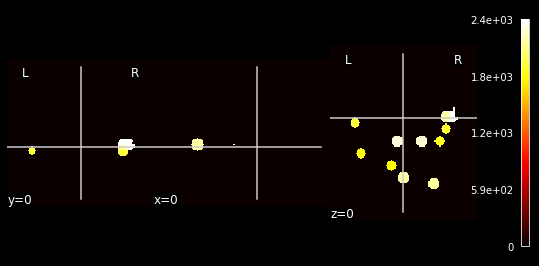

In [21]:
def brainMap(SL_list):

    # convert from SL map to voxel map
    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    coords = np.transpose(np.where(non_nan_mask))
    nVox = coords.shape[0]
    # template
    header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
    template = nib.load(header_fpath)
    # Indices of voxels belonging to each searchlight
    SL_voxels = pickle.load(open('../data/SL/SL_allvox.p', 'rb'))
    # Arrays for voxel maps and voxel searchlight count
    vox_map = np.zeros(nVox)
    voxel_SLcount = np.zeros(nVox)
    # Iterate over searchlights and voxels
    for sl_idx in SL_list:
        voxels_per_sl = SL_voxels[int(sl_idx)]
        vox_map[voxels_per_sl] += int(sl_idx) # voxel gets all its sl contributions
        # Increment the count of searchlights for each voxel
        voxel_SLcount[voxels_per_sl] += 1
    # Identify non-zero voxel counts
    nz_vox = voxel_SLcount > 0
    # Calculate voxel means based on searchlight contributions
    vox_map[nz_vox] = vox_map[nz_vox] / voxel_SLcount[nz_vox]
    # Set values for voxels with no searchlight contribution to NaN
    vox_map[~nz_vox] = np.nan
    # create 3d voxel map [Z,Y,X]
    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    X,Y,Z = non_nan_mask.shape
    vox_coord_map = np.zeros((Z,Y,X))
    vox_coord_map[non_nan_mask] = vox_map.T
    # visualize maps
    img = nib.Nifti1Image(vox_coord_map.T, affine=template.affine, header=template.header)
    nib.save(img, f'./sl_map.nii')
    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)

SL_list = ['1835','1911','2263','2539','1326','2357','1806','3116','1760','2339','4303','2267', '1876', '1915', '3073', '2124', '2146', '2340']
brainMap(SL_list)

## Prep V1 & V2

In [2]:
def prep_vs(version, v):
    main_version = version.split('_')[0]
    all_SLs = np.load(f'./{main_version}/timescales/sig_timescales_SLs.npy', allow_pickle=True).item()
    passing_SLs = np.load(f'./{version}/timescales/sig_timescales_SLs.npy', allow_pickle=True).item()

    done = []
    for s in passing_SLs:
        if s in all_SLs:
            done.append(s)
    left = set(list(passing_SLs.keys())) - set(done)
    left = [sl for sl in left]
    print(len(list(passing_SLs.keys())))
    print(len(done))
    print(len(left))
    print(left)

    for sl in done:
        v_sl_data = np.empty((6), dtype=object)
        sl_data = np.load(f'./{main_version}/timescaleChanges/sl_data/{sl}.npy', allow_pickle=True)
        for repeat in range(6):
            v_sl_data[repeat] = {'true' : None, 'nulls' : []}
            v_sl_data[repeat]['true'] = sl_data[repeat]['true'][f'{v}']
            v_sl_data[repeat]['nulls'] = np.array(sl_data[repeat]['nulls'][f'{v}'])
        np.save(f'./{version}/timescaleChanges/sl_data/{sl}.npy', v_sl_data)

# Intact Maps

## Timescales

In [5]:
version = "intact"
analysis = "timescales"

In [ ]:
#before_big_code(version, analysis, num_processes=3)

In [ ]:
#timescales_data = after_big_code(version, analysis)

In [ ]:
"""
data = np.load("./intact/timescales/timescales_data.npy", allow_pickle=True).item()
data[list(data.keys())[0]].shape
new = {}
for sl in data:
    new[sl] = np.empty((len(np.arange(2,11)),6), dtype=object)
    for i in range(9):
        for j in range(6):
            
            new[sl][i,j] = {}
            new[sl][i,j]['true'] = data[sl][i,j,0]
            new[sl][i,j]['nulls'] = data[sl][i,j,1]
len(new[list(data.keys())[0]][4,3]['nulls'])
np.save("./intact/timescales/timescales_data.npy", new)
"""

In [ ]:
sl_timescales, passing_SLs = timescales_analysis(version, analysis)
# number of surviving SLs: 407

## Timescale Changes

In [61]:
version = "intact"
analysis = "timescaleChanges"

In [ ]:
#before_big_code(version, analysis, num_processes=3)

In [55]:
#timescales_data = after_big_code(version, analysis)

number of SLs: 407


In [60]:
"""
data = np.load("./intact/timescaleChanges/timescales_data.npy", allow_pickle=True).item()
data[list(data.keys())[0]].shape
new = {}
for sl in data:
    new[sl] = np.empty(6, dtype=object)
    for j in range(6):
        new[sl][j] = {}
        new[sl][j]['true'] = data[sl][j]['true']
        new[sl][j]['nulls'] = data[sl][j]['perms']
print(len(new[list(data.keys())[0]][3]['nulls']))
np.save("./intact/timescaleChanges/timescales_data.npy", new)
"""

20


In [ ]:
#fdr_results(version)
# from 17 to 12 survivors

FDR SLs: ['1835','1911','2263','2539','1326','2357','1806','3116','1760','2339','4303','2267']

# Scrambled Fixed

## Timescales

In [16]:
version = "SFix"
analysis = "timescales"

In [ ]:
#before_big_code(version, analysis, num_processes=3)

In [17]:
#timescales_data = after_big_code(version, analysis)

number of SLs: 5354


In [ ]:
#sl_timescales, passing_SLs = timescales_analysis(version, analysis)
# 54 surviving SLs

intact 1806, 2267, 2339, 2357
SRand 1835, 1911, 2263, 2339, 2539, 3116

## Timescale Changes

In [63]:
version = "SFix"
analysis = "timescaleChanges"

In [ ]:
#before_big_code(version, analysis, num_processes=3)

In [21]:
#timescales_data = after_big_code(version, analysis)

number of SLs: 54


In [ ]:
#fdr_results(version)
# from 3 to 2 survivors

FDR SLs: ['1876', '1915']

### Check Data

In [63]:
timescales = np.load(f'./{version}/{analysis}/timescales_data.npy', allow_pickle=True).item()
print(timescales)

{'965': array([{'true': 3.647523700167337, 'nulls': array([7.1084861 , 4.60928099, 4.86041808, 7.15624326, 7.26335815,
              6.01286617, 7.15586742, 5.03640352, 6.00161722, 7.39028429,
              6.31417471, 7.41221853, 6.27471149, 6.74801027, 6.05885   ,
              4.87108997, 7.88678698, 7.79345721, 6.6311874 , 3.55587491])}                                   ,
       {'true': 7.111506933910986, 'nulls': array([3.72463202, 5.16093445, 6.98175267, 5.38358935, 5.05245923,
              5.57201058, 4.57457207, 7.226192  , 5.74007111, 6.40894311,
              6.03063464, 7.24599954, 7.05802786, 5.57098771, 7.65416044,
              6.67134109, 6.80947598, 6.65738844, 6.26246647, 6.91952292])}                                   ,
       {'true': 4.676478788547387, 'nulls': array([5.68147907, 6.6967095 , 7.94811296, 7.18674687, 3.57911287,
              6.17194323, 7.05745906, 7.19507162, 5.09942542, 6.48144223,
              7.59212407, 6.02077181, 6.29252599, 6.08788925, 5.9

In [65]:
# Check if timescales are more than 2
for sl in timescales:
    sl_data = timescales[sl]

    for repeat in range(len(sl_data)):
        sl_repeat = sl_data[repeat]
        for cond in sl_repeat:
            cond_sl_repeat = sl_repeat[cond]

            #for v in cond_sl_repeat:
                #v_cond_sl_repeat = cond_sl_repeat[v]
            if cond == 'true':
                if cond_sl_repeat < 2:
                    print(sl, repeat, cond, cond_sl_repeat, v)
            else:
                for val in cond_sl_repeat:
                    if val < 2:
                        print(sl, repeat, cond, val, v)
sl = list(timescales.keys())[2]

# Check data for anytimescale
sl_timescales = np.load(f'./{version}/{analysis}/sl_data/{sl}.npy', allow_pickle=True)
for repeat in range(6):
    print(sl_timescales[repeat])

{'true': {'v1': 2.770389941968819, 'v2': 7.6601777561324}, 'nulls': {'v1': [3.4720255269186624, 3.0244650637128134, 3.4617263665873663, 2.9244814246961366, 3.5649614813851085, 6.774611462009786, 2.1337645618297905, 5.083112196586441, 5.1344732068365335, 6.878388241091302, 2.366669616734394, 3.0408254248273168, 4.929824465440999, 3.6822538789226935, 2.23921784372683, 4.252175765365383, 5.277240238816926, 3.656986859391228, 5.06389521018966, 4.1547722833352925], 'v2': [8.141510641883654, 6.273622456910405, 8.50240196559894, 6.633729106013139, 2.40088541578707, 6.615091867941557, 6.192181477416349, 6.085719591386824, 3.591374819160668, 7.99274644546129, 6.261233950537882, 5.679372374114807, 8.013973423371946, 7.460659374191694, 8.513862937314832, 8.333286733897413, 7.130369805879293, 6.145702245659293, 8.418804894439887, 6.170489413728435]}}
{'true': {'v1': 5.96276187101285, 'v2': 7.077415060534622}, 'nulls': {'v1': [6.364958711777373, 3.470729567420484, 2.1496842691883877, 6.764198242357

# Scrambled Random

## Timescales

In [28]:
version = "SRnd"
analysis = "timescales"

In [ ]:
#before_big_code(version, analysis, num_processes=3)

In [29]:
#timescales_data = after_big_code(version, analysis)

number of SLs: 5354


In [ ]:
#sl_timescales, passing_SLs = timescales_analysis(version, analysis)
#number of surviving searchlights: 109

## Timescale Changes

In [22]:
version = "SRnd"
analysis = "timescaleChanges"

In [ ]:
#before_big_code(version, analysis, num_processes=3)

In [23]:
#timescales_data = after_big_code(version, analysis)

number of SLs: 109


rest_SLs = [
    "1914", "2558", "1794", "1814", "2557", "2965", "2522", "2130", "2260", "2129",
    "2284", "2681", "2112", "2145", "1022", "3073", "1826", "1365", "2538", "1889",
    "2238", "2949", "2125", "2113", "2315", "2682", "1002", "1793", "1938", "2335",
    "2701", "2128", "977", "2209", "1896", "2659", "1849", "1522", "2123", "1382",
    "2280", "2151", "2527", "1044", "1832", "3136", "2743", "2134", "1910", "2300",
    "2210", "2111", "1361", "2281", "1518"
]

In [ ]:
#fdr_results(version)
# from 8 to 4 SLs

FDR SLs: ['3073', '2124', '2146', '2340']

### Check Data

In [24]:
timescales = np.load(f'./{version}/{analysis}/timescales_data.npy', allow_pickle=True).item()
print(timescales)

{'2130': array([{'true': 6.669402427114463, 'nulls': array([7.06552876, 5.89551104, 5.60700222, 6.42633678, 6.71007426,
              6.05080432, 7.77713125, 5.7328588 , 5.38343538, 6.2330739 ,
              5.94370608, 6.36746097, 7.12974338, 6.24360396, 7.90051236,
              6.08078393, 5.38581349, 5.66906006, 5.88662888, 6.10483728])}                                   ,
       {'true': 7.1957448553556835, 'nulls': array([6.00861716, 6.64680312, 7.28898003, 7.13756342, 6.39827525,
              5.13593565, 6.2698948 , 6.30346429, 7.11922961, 5.94183647,
              5.47030376, 5.70604223, 5.82997171, 6.65705756, 6.73897412,
              6.07680866, 6.16716483, 6.29380576, 6.24233145, 5.07078825])}                                    ,
       {'true': 5.8497655375689535, 'nulls': array([7.02474273, 7.11658042, 5.72744445, 6.81591377, 5.42136601,
              5.43637386, 6.23107865, 6.98083862, 7.5314387 , 5.97444214,
              6.77318598, 6.32623266, 5.41684305, 6.84422187,

In [25]:
# Check if timescales are more than 2
for sl in timescales:
    sl_data = timescales[sl]

    for repeat in range(len(sl_data)):
        sl_repeat = sl_data[repeat]
        for cond in sl_repeat:
            cond_sl_repeat = sl_repeat[cond]

            #for v in cond_sl_repeat:
                #v_cond_sl_repeat = cond_sl_repeat[v]
            if cond == 'true':
                if cond_sl_repeat < 2:
                    print(sl, repeat, cond, cond_sl_repeat, v)
            else:
                for val in cond_sl_repeat:
                    if val < 2:
                        print(sl, repeat, cond, val, v)
sl = list(timescales.keys())[2]


In [26]:
# Check data for anytimescale
sl_timescales = np.load(f'./{version}/{analysis}/sl_data/2209.npy', allow_pickle=True)
for repeat in range(6):
    print(sl_timescales[repeat])

{'true': {'v1': 8.070615634557816, 'v2': 5.162518349780159}, 'nulls': {'v1': [6.416822345850686, 6.100500265232221, 7.308594335147423, 5.0994690042898485, 6.805896633439336, 6.9087051331304545, 6.493190531836088, 5.882474176185969, 6.255588609955137, 7.689832113951992, 6.848620332054172, 6.8623465880836205, 6.014789182384853, 5.7882986840623705, 6.288574332958979, 6.480623008874035, 6.738831019785643, 6.626965897257407, 5.4159254602654086, 6.02390795362468], 'v2': [5.851575318437318, 6.592765560612526, 6.944926800475766, 6.0515792573265, 6.808041149722976, 5.450859376684494, 4.157793191168322, 6.701242453165193, 6.240548882081914, 5.417913256453274, 6.163654691622739, 6.968664460997112, 6.165575275526677, 7.226177018873454, 6.726166721191355, 7.067067081644348, 6.0703086070564165, 5.218807348553906, 6.783847458022889, 6.114019579798899]}}
{'true': {'v1': 8.03897353990683, 'v2': 4.494327456191787}, 'nulls': {'v1': [5.15976113174773, 2.7561035336090303, 4.992070052009451, 6.3086801391483

# Scrambled V1 vs. V2

## SFix

### V1

#### Timescales

In [37]:
version = "SFix_v1"
analysis = "timescales"
v = "v1"

In [41]:
#timescales_data = after_big_code(version, analysis, v)

number of SLs: 5354


In [ ]:
#sl_timescales, passing_SLs = timescales_analysis(version, analysis)
# 3 surviving SLs

intact 1806, 2267, 2339, 2357
SRand 1835, 1911, 2263, 2339, 2539, 3116

#### Timescale Changes

In [38]:
version = "SFix_v1"
analysis = "timescaleChanges"
v = "v1"

In [ ]:
#prep_vs(version, v)
# 3 - 2 = 1
# ['4450']

In [29]:
# Check data for anytimescale
sl_timescales = np.load(f'./{version}/{analysis}/sl_data/4450.npy', allow_pickle=True)
for repeat in range(6):
    print(sl_timescales[repeat])

{'true': 4.7948339359285255, 'nulls': [6.912725478956138, 5.525065280417436, 6.744638424212375, 6.0712712409847, 4.762401667324866, 6.546449964354072, 5.426943034687953, 6.926303739522832, 5.790629143376696, 4.204371298663151, 6.930097254287835, 5.080819046502832, 5.2513040034962915, 6.668918213492916, 6.494436009929572, 7.282212211106931, 7.0933757745997825, 4.74741881196729, 5.183650155400022, 8.030870118195484]}
{'true': 4.076889605538204, 'nulls': [5.552722908227887, 5.505398319240725, 8.53281307135794, 4.586315296867755, 6.80375422043235, 3.7180313157556766, 4.042376315561547, 8.304634917034203, 7.458116629909877, 5.601390457416247, 4.966420067251315, 7.3828687722077895, 5.989162786122923, 5.913070628812933, 5.8643967750952815, 5.1690585381728, 7.984745933927688, 4.782907837552393, 8.008597853721614, 7.3314783669420525]}
{'true': 6.85334148590322, 'nulls': [5.520054834444091, 7.17022076790888, 4.530129712489099, 6.431204681517262, 5.760034015166847, 5.9047676039929575, 7.342151488

In [42]:
timescales_data = after_big_code(version, analysis, v)

number of SLs: 3


In [ ]:
fdr_results(version)
# 0 survivors

### V2

#### Timescales

In [ ]:
version = "SFix_v2"
analysis = "timescales"
v = "v2"

In [ ]:
#timescales_data = after_big_code(version, analysis, v)

number of SLs: 5354


In [ ]:
#sl_timescales, passing_SLs = timescales_analysis(version, analysis)
# 71 surviving SLs

#### Timescale Changes

In [22]:
version = "SFix_v2"
analysis = "timescaleChanges"
v = "v2"

In [71]:
#prep_vs(version, v)
# 71 - 20 = 51
# ['1485', '1524', '2540', '1334', '1518', '2980', '2128', '1383', '2987', '2969', '2125', '2521', '1332', '1003', '3015', '2533', '3073', '2951', '2697', '4080', '2110', '2171', '2527', '2964', '2514', '2601', '2539', '663', '1856', '986', '3351', '2566', '1004', '1317', '2970', '1325', '1346', '1754', '2569', '2965', '2953', '2146', '2611', '1351', '1761', '2600', '1741', '4092', '2937', '968', '2163']

71
20
51
['1485', '1524', '2540', '1334', '1518', '2980', '2128', '1383', '2987', '2969', '2125', '2521', '1332', '1003', '3015', '2533', '3073', '2951', '2697', '4080', '2110', '2171', '2527', '2964', '2514', '2601', '2539', '663', '1856', '986', '3351', '2566', '1004', '1317', '2970', '1325', '1346', '1754', '2569', '2965', '2953', '2146', '2611', '1351', '1761', '2600', '1741', '4092', '2937', '968', '2163']


In [ ]:
# Check data for anytimescale
sl_timescales = np.load(f'./{version}/{analysis}/sl_data/1485.npy', allow_pickle=True)
for repeat in range(6):
    print(sl_timescales[repeat])

{'true': 4.7948339359285255, 'nulls': [6.912725478956138, 5.525065280417436, 6.744638424212375, 6.0712712409847, 4.762401667324866, 6.546449964354072, 5.426943034687953, 6.926303739522832, 5.790629143376696, 4.204371298663151, 6.930097254287835, 5.080819046502832, 5.2513040034962915, 6.668918213492916, 6.494436009929572, 7.282212211106931, 7.0933757745997825, 4.74741881196729, 5.183650155400022, 8.030870118195484]}
{'true': 4.076889605538204, 'nulls': [5.552722908227887, 5.505398319240725, 8.53281307135794, 4.586315296867755, 6.80375422043235, 3.7180313157556766, 4.042376315561547, 8.304634917034203, 7.458116629909877, 5.601390457416247, 4.966420067251315, 7.3828687722077895, 5.989162786122923, 5.913070628812933, 5.8643967750952815, 5.1690585381728, 7.984745933927688, 4.782907837552393, 8.008597853721614, 7.3314783669420525]}
{'true': 6.85334148590322, 'nulls': [5.520054834444091, 7.17022076790888, 4.530129712489099, 6.431204681517262, 5.760034015166847, 5.9047676039929575, 7.342151488

In [ ]:
timescales_data = after_big_code(version, analysis, v)

number of SLs: 3


## SRnd

### V1

#### Timescales

In [60]:
version = "SRnd_v1"
analysis = "timescales"
v = "v1"

In [34]:
#timescales_data = after_big_code(version, analysis, v)

number of SLs: 5354


In [ ]:
#sl_timescales, passing_SLs = timescales_analysis(version, analysis)
# 26 surviving SLs

#### Timescale Changes

In [25]:
version = "SRnd_v1"
analysis = "timescaleChanges"
v = "v1"

In [67]:
#prep_vs(version, v)
# 26 - 17 = 9
# ['1404', '4470', '1540', '1890', '2995', '3086', '987', '1023', '2737']

26
17
9
['1404', '4470', '1540', '1890', '2995', '3086', '987', '1023', '2737']


In [26]:
# Check data for any timescale
sl_timescales = np.load(f'./{version}/{analysis}/sl_data/1404.npy', allow_pickle=True)
for repeat in range(6):
    print(sl_timescales[repeat])

{'true': 6.0644830628245865, 'nulls': [7.282637857231196, 7.380574039317737, 5.952232332694584, 6.663656414282263, 6.651651124128768, 6.334725288394455, 6.379457705407284, 7.043457891547891, 4.826547199455491, 6.7274179620696115, 5.9881959074038145, 6.756416322687638, 7.348735786731149, 7.39075608745149, 6.27086218413865, 7.298960971994645, 6.777442747670669, 6.9072297287833635, 6.839990706563884, 6.586562009705056]}
{'true': 7.169905066164059, 'nulls': [6.277861515578771, 5.361152736446245, 3.937805617696764, 5.893361818727582, 5.859338576333743, 7.4038237958560424, 6.496050143817176, 6.03950818390504, 6.1521619909977, 6.612346606868522, 5.712980020390619, 7.981407624847408, 7.494477935842662, 6.653109149638065, 5.604946703666083, 6.3849789238926755, 7.31987321834519, 5.558054616349313, 6.584304435178582, 7.288567897083906]}
{'true': 6.839178473112062, 'nulls': [4.603629263478486, 6.971378638238744, 6.956964536276275, 6.83241418425447, 6.750235117580044, 6.753340556879236, 5.641995735

In [27]:
timescales_data = after_big_code(version, analysis, v)

number of SLs: 26


In [ ]:
fdr_results(version)
# from 1 to 0 survivors

### V2

#### Timescales

In [37]:
version = "SRnd_v2"
analysis = "timescales"
v = "v2"

In [38]:
#timescales_data = after_big_code(version, analysis, v)

number of SLs: 5354


In [ ]:
#sl_timescales, passing_SLs = timescales_analysis(version, analysis)
# 31 surviving SLs

#### Timescale Changes

In [29]:
version = "SRnd_v2"
analysis = "timescaleChanges"
v = "v2"

In [ ]:
#prep_vs(version, v)
# 31 - 19 = 12
# ['985', '2559', '1537', '4742', '2540', '2117', '2534', '2978', '4744', '2118', '3249', '2299']

In [30]:
# Check data for any timescale
sl_timescales = np.load(f'./{version}/{analysis}/sl_data/985.npy', allow_pickle=True)
for repeat in range(6):
    print(sl_timescales[repeat])

{'true': 5.845891216629285, 'nulls': [6.532183660429977, 6.852893613305197, 7.155123838496289, 6.2926326483879125, 7.281064348706952, 5.1474107383055525, 7.875090340868157, 6.835704746762482, 6.22287009503628, 6.470321361355556, 5.989864184748125, 6.8858341546811435, 7.691943452394197, 6.0824486131028985, 5.25551784906757, 7.368782109740723, 6.609449462080571, 5.96741051816257, 6.161134881365225, 6.41219532482798]}
{'true': 5.809112905726518, 'nulls': [6.168946032821297, 5.882183662884384, 5.1553175223635295, 6.472053047001961, 6.882425594402038, 5.959856627389142, 6.85767163622622, 7.190894063586149, 6.73712969126175, 6.711891410085318, 7.132563780430532, 6.072299328147907, 6.234120248130751, 5.512851210257861, 7.257832788791397, 6.885025249210721, 6.639777579449569, 6.718836361115713, 6.584773643361572, 7.046158349026982]}
{'true': 6.8737303411454995, 'nulls': [6.511587439818073, 5.8645463423920114, 4.997357284232627, 7.204123616954498, 4.389013639929312, 6.029389341702889, 6.9910083

In [31]:
timescales_data = after_big_code(version, analysis, v)

number of SLs: 31


In [ ]:
fdr_results(version)
# from 1 to 1 survivors
# ['2111']

# Boundary Location Annotations

In [ ]:
# from '/data/gbh/data/ev_annots.ipynb'

ev_annot = np.asarray(
        [5, 12, 54, 77, 90,
        3, 12, 23, 30, 36, 43, 50, 53, 78, 81, 87, 90,
        11, 23, 30, 50, 74,
        1, 55, 75, 90,
        4, 10, 53, 77, 82, 90,
        11, 54, 77, 81, 90,
        12, 22, 36, 54, 78,
        12, 52, 79, 90,
        10, 23, 30, 36, 43, 50, 77, 90,
        13, 55, 79, 90,
        4, 10, 23, 29, 35, 44, 51, 56, 77, 80, 85, 90,
        11, 55, 78, 90,
        11, 30, 43, 54, 77, 90,
        4, 11, 24, 30, 38, 44, 54, 77, 90]
    )

In [ ]:
len(ev_annot)

89

In [ ]:
len(passing_SFix_LLs)

54

# ROIs

## Posterior Hippocampus